# A. General Steps

## A.1. Download the data

In [ ]:
# 1. Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Imports & path setup
from fastai.vision.all import *
import pandas as pd

data_path = Path('/content/drive/MyDrive/Colab Notebooks/archive/faces')

# 3. Peek at the CSV
df = pd.read_csv(data_path/'train.csv')
print(df.shape)
display(df.head())
print(df['Class'].value_counts())


Mounted at /content/drive
(19906, 2)


,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


Class
MIDDLE    10804
YOUNG      6706
OLD        2396
Name: count, dtype: int64


## A.2. Create the DataBlock and dataloaders


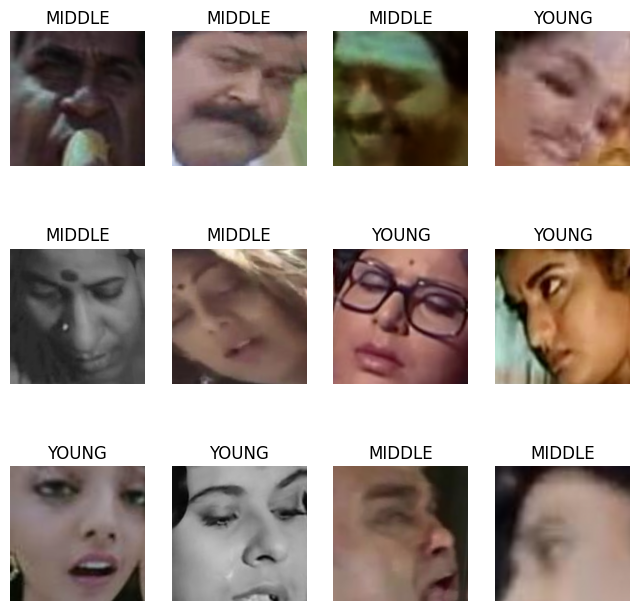

In [ ]:
# 4. Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),               # A.2.1: image in, category out
    get_x=ColReader('ID', pref=data_path/'Train'),
                                                      # A.2.2: how to get the file path
    get_y=ColReader('Class'),                         # A.2.3: how to get the class
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 80/20 train/val
    item_tfms=Resize(460),                            # presize to avoid aug artifacts
    batch_tfms=[
        *aug_transforms(size=224, max_rotate=10),     # A.2.4: augment+resize
        Normalize.from_stats(*imagenet_stats)         # imagenet normalization
    ]
)

# 5. Create your DataLoaders
dls = dblock.dataloaders(df, bs=64)  # bs=64 is a good starting point

# 6. Inspect your DataLoaders
dls.show_batch(max_n=12, figsize=(8,8))   # A.3.1: visualize a batch



## A.3. Inspect the DataBlock via dataloader

In [ ]:
dblock.summary(df)

Setting-up type transforms pipelines
0        377.jpg  MIDDLE
1      17814.jpg   YOUNG
2      21283.jpg  MIDDLE
3      16496.jpg   YOUNG
4       4487.jpg  MIDDLE
...          ...     ...
19901   2482.jpg  MIDDLE
19902  20085.jpg   YOUNG
19903  19663.jpg  MIDDLE
19904  10132.jpg  MIDDLE
19905   9896.jpg  MIDDLE

[19906 rows x 2 columns]
Found 19906 items
2 datasets of sizes 15925,3981
Setting up Pipeline: ColReader -- {'cols': 'ID', 'pref': Path('/content/drive/MyDrive/Colab Notebooks/archive/faces/Train'), 'suff': '', 'label_delim': None} -> PILBase.create
Setting up Pipeline: ColReader -- {'cols': 'Class', 'pref': '', 'suff': '', 'label_delim': None} -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: ColReader -- {'cols': 'ID', 'pref': Path('/content/drive/MyDrive/Colab Notebooks/archive/faces/Train'), 'suff': '', 'label_delim': None} -> PILBase.create
    starting from
      ID       21545.jpg
Class        YOUNG
Name: 11389, dtype: object

## A.4. Train a simple model

In [ ]:
from fastai.vision.all import *

# 1. Instantiate a Learner using a pretrained CNN
learn = vision_learner(
    dls,               # your DataLoaders
    resnet34,
    metrics=accuracy   # track classification accuracy
).to_fp16()

# 2. Fine-tune for a few epochs
learn.fine_tune(
    4,                 # total epochs (1-2 for head, 2-3 for unfreeze)
    base_lr=3e-3
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,1.035165,0.805963,0.629239,13:05


epoch,train_loss,valid_loss,accuracy,time
0,0.707279,0.626141,0.734991,00:39
1,0.578291,0.479147,0.805325,00:39
2,0.429968,0.407222,0.839488,00:39
3,0.345980,0.357053,0.855815,00:39


### A.4.1. Create a benchmark


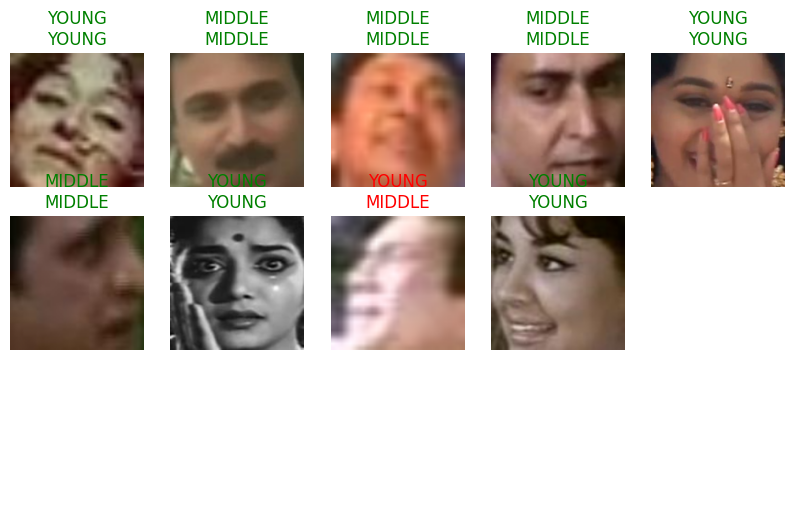

In [ ]:
# Show a few prediction examples
learn.show_results(
    nrows=3,
    ncols=5,
    figsize=(10,6)
)

### A.4.2. Interpret the model
### A.4.3. Confusion matrix


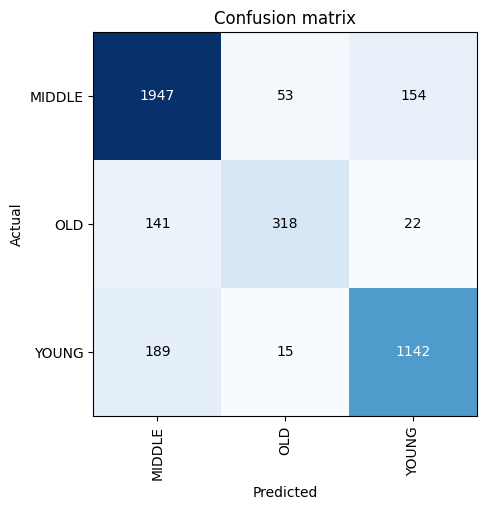

In [ ]:
# 1. Produce an interpreter
interp = ClassificationInterpretation.from_learner(learn)

# 2. Plot confusion matrix
interp.plot_confusion_matrix(
    figsize=(5,5),
    dpi=100
)

## B.1. Learning Rate Finder

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


Minimum-loss lr: 1.10e-05, Steepest-slope lr: 1.10e-06


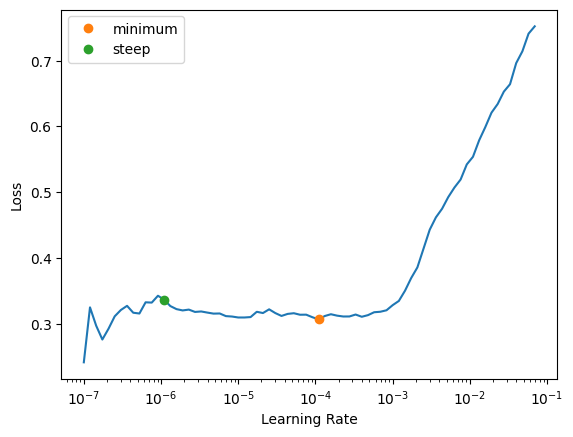

In [ ]:
# 1. Launch the LR finder
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

# 2. Print out the suggested values
print(f"Minimum-loss lr: {lr_min:.2e}, Steepest-slope lr: {lr_steep:.2e}")

In [ ]:
# let's choose 1e-4 by examining the graph
learn.fine_tune(4, base_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.316301,0.358574,0.856066,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.307941,0.355827,0.858076,00:39
1,0.301552,0.352268,0.857322,00:39
2,0.294246,0.350327,0.862597,00:39
3,0.290164,0.349613,0.861844,00:39


## B.3. Transfer Learning (One or more final linear layers)

In [ ]:
# 1. Re-freeze the body and train just the head longer:
learn.freeze()
learn.fit_one_cycle(2, 1e-3)   # head only, 2 epochs

# 2. Unfreeze everything
learn.unfreeze()

# 3. Train head + body at same LR
learn.fit_one_cycle(2, 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.300523,0.375153,0.858076,00:35
1,0.281145,0.349450,0.864858,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.379397,0.383447,0.843758,00:39
1,0.275035,0.321139,0.870384,00:39


## B.4. Discriminative Learning Rates


In [ ]:
# 1. Unfreeze if not already
learn.unfreeze()

# 2. Define a slice: (earliest_lr, head_lr)
lr_slice = slice(1e-6, 1e-4)

# 3. Train with one-cycle policy
learn.fit_one_cycle(
    4,          # total epochs
    lr_slice,   # discriminative rates
    pct_start=0.8  # spend 80% of the cycle increasing LR
)

learn.export('best_model')

epoch,train_loss,valid_loss,accuracy,time
0,0.227468,0.321337,0.871138,00:39
1,0.235733,0.328551,0.874655,00:39
2,0.221673,0.323171,0.877418,00:39
3,0.201156,0.324644,0.881939,00:39


## B.5 Deciding the Number of Training Epochs

In [ ]:
from fastai.callback.tracker import EarlyStoppingCallback

# B.5.1: Retrain your model with the chosen LR and minimal epochs (no LR Finder)
learn.fit_one_cycle(4, slice(1e-6,1e-4))

# B.5.2/5.3
learn = vision_learner(dls, resnet34, metrics=accuracy).to_fp16()
learn.freeze()
learn.fit_one_cycle(2, 1e-3)         # head-only
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-6,1e-4),
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3)])

/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.178414,0.331749,0.878171,00:39
1,0.189066,0.331427,0.882442,00:39
2,0.173767,0.324872,0.884451,00:39
3,0.158868,0.322306,0.885205,00:39


epoch,train_loss,valid_loss,accuracy,time
0,1.082177,0.765041,0.673198,00:33
1,0.862206,0.693782,0.708365,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.845055,0.677837,0.714393,00:39
1,0.794072,0.640194,0.725195,00:40
2,0.735647,0.606501,0.740266,00:39
3,0.710096,0.570621,0.759106,00:39
4,0.656633,0.544118,0.773675,00:39
5,0.605600,0.537625,0.776438,00:39
6,0.575130,0.524083,0.780960,00:39
7,0.586405,0.515613,0.784979,00:39
8,0.563605,0.513488,0.785481,00:39
9,0.558942,0.512132,0.782216,00:39


## B.6 Model Capacity

In [13]:
# B.6.1/6.2: If you increase model capacity (e.g. ResNet50), reduce batch size to avoid OOM
dls_small_bs = dblock.dataloaders(df, bs=32)
learn50 = vision_learner(dls_small_bs, resnet50, metrics=accuracy).to_fp16()
learn50.fine_tune(4, base_lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,1.514459,1.071316,0.522984,00:55


epoch,train_loss,valid_loss,accuracy,time
0,1.358728,0.958019,0.584024,01:05
1,1.221653,0.867099,0.624717,01:04
2,1.185570,0.830999,0.638784,01:04
3,1.186092,0.827071,0.643557,01:05


## Huggingface Login

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

## Create the necessary space on Huggingface

In [ ]:
from huggingface_hub import HfApi, Repository

SPACE_NAME = "Balghi/age-classifier-gradio"
api = HfApi()
api.create_repo(repo_id=SPACE_NAME, repo_type="space", space_sdk="gradio", exist_ok=False)

# Clone it locally
repo = Repository(local_dir="hf_space", clone_from=SPACE_NAME, repo_type="space")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/spaces/Balghi/age-classifier-gradio into local empty directory.
